In [3]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm

# Univariate Distribution
Let $P(x) = 3e^{-\frac{x^2}{2}} + e^{-\frac{(x-4)^2}{2}}$ be the distribution we want to sample from. Note that this is an unnormalized distribution with a normalizing constant $Z$ we can compute but let's keep it as it is.     
($Z \approx 10.0261955464$)

In [4]:
P = lambda x: 3 * np.exp(-x*x/2) + np.exp(-(x - 4)**2/2)
Z = 10.0261955464

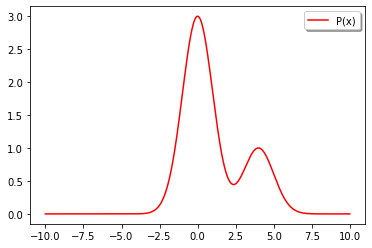

In [5]:
x_vals = np.linspace(-10, 10, 1000)
y_vals = P(x_vals)
plt.figure(1)
plt.plot(x_vals, y_vals, 'r', label='P(x)')
plt.legend(loc='upper right', shadow=True)
plt.show()

Let the functions that we want to approximate be $f(x) = x$ and $g(x) = \sin(x)$. The two values for a unnormalized $P$ are as follows:
* $\mathbb{E}[x] \approx 10.02686647165 $
* $\mathbb{E}[\sin(x)] \approx -1.15088010640 $

In [6]:
f_x = lambda x: x
g_x = lambda x: np.sin(x)
true_expected_fx = 10.02686647165
true_expected_gx = -1.15088010640

### Metropolis Hastings
For any $P(x)$, the Metropolis-Hastings algorithm proceeds as follows.
* Start at some $x_t = x_0$.
* Sample $x_i \sim Q(x|x_t)$
* $A = \min\Big(\frac{P(x_i)Q(x_t|x_i)}{P(x_t)Q(x_i|x_t)},1\Big)$
* Sample $k_i \sim Uniform[0,1]$
    * if $k_i < A$ then $x_{t+1} = x_i$
    * else $x_{t+1} = x_t$
    
As $t \rightarrow \infty$, $x_t$ comes from a normalized $P(x)$. The Markov chain takes some time to stabilize which is the burn-in phase. In the following code we ignore the first 1000 samples as burn-in.   
Here we choose $Q(x|x_t)$ as $\mathcal{N}(x_t, 1)$ which is actually equal to $Q(x_t|x)$ and should cancel but I have added it in the code for clarity.

In [30]:
Q = lambda t1, t0: np.exp(-(t1 - t0)**2/2)/(np.sqrt(2 * np.pi))
x0 = 0
xt = x0
samples = []
for i in range(100000):
    xt_candidate = np.random.normal(xt, 1)
    accept_prob = (P(xt_candidate) * Q(xt, xt_candidate))/(P(xt) * Q(xt_candidate, xt))
    if np.random.uniform(0, 1) < accept_prob:
        xt = xt_candidate
    samples.append(xt)
burn_in = 1000
samples = np.array(samples[burn_in:])
expected_f_x = np.mean(f_x(samples))
expected_g_x = np.mean(g_x(samples))
expected_f_x *= Z
expected_g_x *= Z
print('E[f(x)] = %.5f, Error = %.5f' % (expected_f_x, abs(expected_f_x - true_expected_fx)))
print('E[g(x)] = %.5f, Error = %.5f' % (expected_g_x, abs(expected_g_x - true_expected_gx)))

E[f(x)] = 10.20065, Error = 0.17378
E[g(x)] = -1.11605, Error = 0.03483


Compute the histogram of samples from Metropolis Hastings and compare it with normalized $P(x)$. It's clear that Metropolis Hastings algorithm generates samples from underlying normalized $P(x)$.

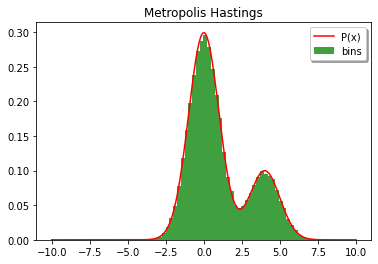

In [31]:
plt.hist(samples, bins=50, histtype='bar', facecolor='g', alpha=0.75, density=1, label='bins')
plt.plot(x_vals, y_vals/Z, 'r', label='P(x)')
plt.title('Metropolis Hastings')
plt.legend(loc='upper right', shadow=True)
plt.show()

# Bivariate Distribution

Let $U(\mathbf{z}) = \frac{1}{2}\left(\frac{\|\mathbf{z}\|-2}{0.4}\right)^2 - \log\left(e^{-0.5\left[\frac{\mathbf{z}_1 - 2}{0.6}\right]} + e^{-0.5\left[\frac{\mathbf{z}_1 + 2}{0.6}\right]}\right)$; and $p(\mathbf{z}) = e^{-\left[U(\mathbf{z})\right]}$ be the unnormalized distribution we want to sample from.

In [25]:
def density1(z):
    z = np.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)

### Plot the true density

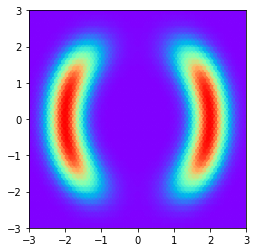

In [26]:
r = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(r, r)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

q0 = density1(z)
plt.hexbin(z[:,0], z[:,1], C=q0.squeeze(), cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

Use MH with multivariate normal as the proposal

In [35]:
def metropolis_hastings(target_density, size=1000000):
    burnin_size = 10000
    size += burnin_size
    x0 = np.array([[0, 0]])
    xt = x0
    samples = []
    for i in tqdm(range(size)):
        xt_candidate = np.array([np.random.multivariate_normal(xt[0], np.eye(2))])
        accept_prob = (target_density(xt_candidate))/(target_density(xt))
        if np.random.uniform(0, 1) < accept_prob:
            xt = xt_candidate
        samples.append(xt)
    samples = np.array(samples[burnin_size:])
    samples = np.reshape(samples, [samples.shape[0], 2])
    return samples

In [ ]:
samples = metropolis_hastings(density1)

 89%|███████████████████████████████████████████████████████████████        | 896744/1010000 [02:40<00:18, 6223.79it/s]

Plot the histogram of samples

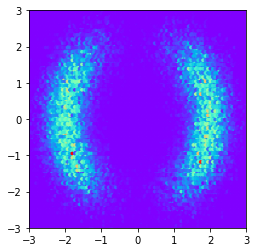

In [34]:
plt.hexbin(samples[:,0], samples[:,1], cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()